### Emma Klemets, 260775167   
All my work, code, output and written answers are in this notebook.

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy import integrate
import math

### Problem 1
Write a recursive variable step size integrator like the one we
wrote in class that does NOT call f(x) multiple times for the same x. For a few typical examples, how many function calls do you save vs. the lazy way we wrote it in class?

In [50]:
def simple_integrate(fun,a,b,tol, text=False):
    
    #x to intrate over
    x=np.linspace(a,b,5)
    #dx from x range
    dx=(b-a)/4.0
    #np.median(np.diff(x))
    y=fun(x)
    
    neval=len(x) #let's keep track of function evaluations
    
    #get error of region
    f1=(y[0]+4*y[2]+y[4])/6.0*(b-a)
    f2=(y[0]+4*y[1]+2*y[2]+4*y[3]+y[4])/12.0*(b-a)
    
    myerr=np.abs(f2-f1)
    
    if text:
        print("interval: ({}, {}), {} {}".format(a,b,f1,f2))
    
    #if within tolerance, return value
    if (myerr<tol):
        #return (f2)/1.0,myerr,neval
        return (16.0*f2-f1)/15.0,myerr,neval
    else: #else split interval and call again
        mid=0.5*(b+a) #split usign new midpoint
        
        f_left,err_left,neval_left=simple_integrate(fun,a,mid,tol/2.0, text=text)
        
        f_right,err_right,neval_right=simple_integrate(fun,mid,b,tol/2.0, text=text)
        
        #put results from split together
        neval=neval+neval_left+neval_right
        f=f_left+f_right
        err=err_left+err_right
        
        return f,err,neval

In [51]:
def simple_integrate_smart(fun,a,b,tol, edges=['n', 'n'], text=False):
    
    #x to intrate over
    x=np.linspace(a,b,5)
    #dx from x range
    dx=(b-a)/4.0

    #For start there are no edge values calculated
    if isinstance(edges[0], str):
        y=fun(x)
        #keep track of function evaluations
        neval=len(x)

    else:
        y=np.concatenate(([edges[0]], fun(x[1:-1]), [edges[1]]))
        #keep track of function evaluations
        neval=len(x[1:-1])
#         print(x[0], x[-1], a, b   
    
    #get error of region
    f1=(y[0]+4*y[2]+y[4])/6.0*(b-a)
    f2=(y[0]+4*y[1]+2*y[2]+4*y[3]+y[4])/12.0*(b-a)
    
    myerr=np.abs(f2-f1)
    
    if text:
        print("interval: ({}, {}), {} {}".format(a,b,f1,f2))
    
    #if within tolerance, return value
    if (myerr<tol):
        #return (f2)/1.0,myerr,neval
        return (16.0*f2-f1)/15.0,myerr,neval
    else: #else split interval and call again
        mid=0.5*(b+a) #split usign new midpoint
        
        f_left,err_left,neval_left=simple_integrate_smart(fun,a,mid,tol/2.0, [y[0], y[2]], text=text)
        
        f_right,err_right,neval_right=simple_integrate_smart(fun,mid,b,tol/2.0, [y[2], y[-1]], text=text)
        
        #put results from split together
        neval=neval+neval_left+neval_right
        f=f_left+f_right
        err=err_left+err_right
        
        return f,err,neval

In [52]:
#functions to fit
sig=0.1

def fun(x):
    return 1.0/(1.0+x**2)

def fun2(x):
    return 1.0+np.exp(-0.5*x**2/(sig**2))

In [53]:
#TO DO: loop through a couple functions

#function from class
f,err,neval=simple_integrate(np.exp,-1,1,1e-3)
#my smarter function
my_f,my_err,my_neval=simple_integrate_smart(np.exp,-1,1,1e-3)#, text=True)

#exact value
pred=np.exp(1)-np.exp(-1)

#print results
print("value: {:.4e} +/- {:.4e}, function calls: {}".format(f,err,neval))
print("Smart function: \nmy_value: {:.4e} +/- {:.4e}, function calls: {}".format(my_f,my_err,my_neval))

print("Saves {} functions calls. True error: {:.4e}".format(neval-my_neval, np.abs(pred-my_f)))

value: 2.3504e+00 +/- 2.3419e-04, function calls: 25
Smart function: 
my_value: 2.3504e+00 +/- 2.3419e-04, function calls: 17
Saves 8 functions calls. True error: 3.2994e-07


### Problem 2: 
a) Write a function that models the log base 2 of x valid from 0.5 to 1 to an accuracy in the region better than 10−6. Please use a truncated Chebyshev polynomial fit to do this, and please write your own fit routine.   

- How many terms do you need?
    - Carry out a polynomial fit of the same order (we’ll see how to do this ourselves in coming lectures, but for now I suggest just calling np.polynomial.legendre.legfit, which will be more stable than np.polyfit).   
- Plot the residuals for both the truncated Chebyshev and standard polynomial fits. 
    - Which one has higher RMS error? Which one has a larger max error?

In [190]:
log = lambda x: [math.log2(i) for i in x]


Chebyshev Polynomials   
$T_n = cos(n~arccos(x)) ~~ -1 \leq x \leq 1$   
$T_0=1, T_1=x$  
$T_{n+1}=2x\cdot T_N - T_{n-1}$

Need to scale to (0.5, 1)  
x --> 4x-3

In [196]:
#fit scaled chebyshev polynominals for function fun and order ord
def cheb_fit(fun,ord):
    x=np.linspace(0.5,1,ord+1)
    y=fun(x)
    
    mat=np.zeros([ord+1,ord+1])
    #set t0 and t1 values
    mat[:,0] = 1
    mat[:,1] = 4*x - 3 #for scaling to [0.5, 1]
    
    #fill other Chebyshev Polynomials using recurrence relation
    for i in range(1,ord):
        mat[:,i+1]=2*(4*x - 3)*mat[:,i]-mat[:,i-1]
                
    #invert matric and mutliply by y to get coeffs
    coeffs=np.linalg.inv(mat)@y
    return coeffs

def cheb_vals(c, ord):
    x=np.linspace(0.5,1,ord+1)
    
    mat=np.zeros([ord+1,ord+1])
    #set t0 and t1 values
    mat[:,0] = 1
    mat[:,1] = 4*x - 3
    
    #fill other Chebyshev Polynomials using recurrence relation
    for i in range(1,ord):
        mat[:,i+1]=2*(4*x - 3)*mat[:,i]-mat[:,i-1]
        
    #mulitply by coeff to get y values
    return mat@c

In [235]:
#do cheb fit to see what order is needed
deg = 20

coeffs=cheb_fit(log, deg)
cheb_fitted = cheb_vals(coeffs, deg)
print(coeffs)

[-4.56893394e-01  4.95054673e-01 -4.24689768e-02  4.85768297e-03
 -6.25084976e-04  8.57981013e-05 -1.22671891e-05  1.80404310e-06
 -2.70834249e-07  4.13046060e-08 -6.37817266e-09  9.94862859e-10
 -1.56546776e-10  2.47801779e-11 -3.92219590e-12  6.43041176e-13
 -8.52651283e-14  1.42108547e-14  1.42108547e-14  4.44089210e-16
  3.55271368e-15]


In [236]:
# coeffs
x = np.array([0.3, 0.5, 0.6, 1.1, 2, 3, 4, 5])
smaller = np.where(np.abs(coeffs) < 1.0e-6)
# smaller = np.where(x <= 1)

print( "For 10^-6 accuracy, we need at least order {} or larger, as this coeff's value is {:.2e}.".format(smaller[0][0], coeffs[smaller[0][0]]) )

For 10^-6 accuracy, we need at least order 8 or larger, as this coeff's value is -2.71e-07.


In [237]:
#do actual fit with reasonable order

deg = 10

coeffs=cheb_fit(log, deg)
cheb_fitted = cheb_vals(coeffs, deg)

x=np.linspace(0.5,1,deg+1)
y=log(x)

In [239]:
cheb_rms = np.std(np.abs(cheb_fitted-y))
cheb_maxErr = np.max(np.abs(cheb_fitted-y))
print(cheb_rms, cheb_maxErr)
# print(np.abs(cheb_fitted-y))

3.4233788080261183e-16 1.1102230246251565e-15


In [241]:
#polyfit 
xp = np.linspace(0.5, 1, 100) #should this be for the same number of points?
# print(x)
yp = [math.log2(i) for i in xp]

# Return the coefficients of a Legendre series, [residuals, rank, singular_values, rcond]
polyfit, polyfit_info = np.polynomial.legendre.legfit(xp, yp, deg, full=True)

polyfit_leg = np.polynomial.legendre.legval(xp, polyfit)


In [245]:
# RMS, max error

poly_rms = np.std(np.abs(polyfit_leg-yp))

poly_maxErr = np.max(np.abs(polyfit_leg-yp))
print(poly_rms, poly_maxErr)

3.4111492464941453e-10 1.9303740828036098e-09


C:\Users\Emma\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


For order 10
For chebyshev, rms: 3.4234e-16, max error: 1.1102e-15
For polynominal, rms: 3.4111e-10, max error: 1.9304e-09


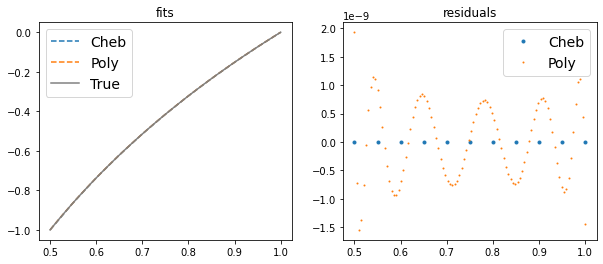

In [246]:
#plotting fit and residuals
fig, ax = plt.subplots(1, 2, figsize=(10,4))

ax[0].plot(x, cheb_fitted, label='Cheb', ls="--")
ax[0].plot(xp, polyfit_leg, label='Poly', ls="--")
ax[0].plot(xp, log(xp), label='True', color="grey")

ax[0].set_title("fits")
ax[0].legend(prop={'size': 14})

ax[1].plot(x, cheb_fitted-y, label='Cheb', ls="", marker=".")
ax[1].plot(xp, polyfit_leg-yp, label='Poly', ls="", marker=".", markersize=2)

ax[1].set_title("residuals")
ax[1].legend(prop={'size': 14})
# ax[1].set_ylabel("f' exact - f' approx")

fig.show()

#rms and max errors
print("For order {}".format(deg))
print("For chebyshev, rms: {:.4e}, max error: {:.4e}".format(cheb_rms, cheb_maxErr))
print("For polynominal, rms: {:.4e}, max error: {:.4e}".format(poly_rms, poly_maxErr))

In [247]:
#comparing results
if cheb_rms > poly_rms:
    print("Chebyshev has a larger RMS value,")
else:
    print("The polynomial has a larger RMS value,")
    
if cheb_maxErr > poly_maxErr:
    print(" and Chebyshev has a larger maximum error.")
else:
    print("and the polynomial has a larger maximum error.")


The polynomial has a larger RMS value,
and the polynomial has a larger maximum error.


### Problem 3: 

#### a) 
*Write a program to solve for the decay products of U238 (refer to slides for the decay chain). You can use the ODE solver from scipy, but you’ll need to set the problem up properly. Please make sure to include all the decay prodcuts in the chain. Assume you start from a sample of pure U238 (in nature, this sort of separation happens chemically when rocks are formed). Which solver would you use for this problem?*

$dN/dt = -\lambda N(t) = -\frac{ln(2)}{t_{1/2}} N(t)$


It's a stiff equation, as the different products have very different half-lifes, from billions of years to microseconds, so we need to account for this, especailly if we want an efficent fitter. Using the Radau method as in class with solve_ivp() will help with this.

In [248]:
from scipy import integrate
 
# start: pure U238  --> N=1
# scipy.integrate.solve_ivp(fun, t_span, y0, method='RK45', 
# t_eval=None, dense_output=False, events=None, vectorized=False, args=None, **options)

# half_life=[1,1e-5] #put all my half life values in an array here in order?

# http://holbert.faculty.asu.edu/eee460/RadioactiveDecay.pdf

half_lifeTable = {
    "U238": 4.468, #bil years,
    "Th234": 2410, #days,
    "Pa234": 6.70, #Hrs
    "U234": 245500,#years
    "Th230": 75380,#years
    "Ra226": 1600,#years
    "Rn222": 3.8234, #days
    "Po218": 3.10, #Min
    "Pb214": 26.8, #min
    "Bi214": 19.9, #min
    "Po214": 164.3, #microsec
    "Pb210": 22.3, #years
    "Bi210": 5.015, #years #days says wiki?
    "Po210": 138.376, #days
    "Pb206": "stable"  
}

half_lifes_dict = { #in seconds
    "U238": 4.468*60*60*24*365.24*1e9, #bil years,
    "Th234": 2410*60*60*24, #days,
    "Pa234": 6.70*60*60, #Hrs
    "U234": 245500*60*60*24*365.24,#years
    "Th230": 75380*60*60*24*365.24,#years
    "Ra226": 1600*60*60*24*365.24,#years
    "Rn222": 3.8234*60*60*24, #days
    "Po218": 3.10*60, #Min
    "Pb214": 26.8*60, #min
    "Bi214": 19.9*60, #min
    "Po214": 164.3*1e-6, #microsec
    "Pb210": 22.3*60*60*24*365.24, #years
    "Bi210": 5.015*60*60*24, #years #days says wiki?
    "Po210": 138.376*60*60*24, #days
#     "Pb206": "stable"  
}

# half_lives = np.array(list(half_lifes_dict.items()))[:-1,1] #* 60*60*24*365.24
# print(half_lifes_dict)

half_lives = np.fromiter(half_lifes_dict.values(), dtype=float) #seconds

print(half_lives)

[1.40995496e+17 2.08224000e+08 2.41200000e+04 7.74717869e+12
 2.37874676e+12 5.04907776e+10 3.30341760e+05 1.86000000e+02
 1.60800000e+03 1.19400000e+03 1.64300000e-04 7.03715213e+08
 4.33296000e+05 1.19556864e+07]


In [138]:
def fun(x,y,half_life=[1,1e-5]):
    #let's do a 2-state radioactive decay
    
    dydx=np.zeros(len(half_life)+1) 
    
    #first decay
    dydx[0]=-y[0]/half_life[0]
    
    #second decay comes from production of [0] but also still decays [1]
    dydx[1]=y[0]/half_life[0]-y[1]/half_life[1]
    
    #final product doesn't decay, only comes from production of [1]
    dydx[2]=y[1]/half_life[1]
    
    return dydx

def fun_mine(x,y,half_life=half_lives):
    
    dydx=np.zeros(len(half_life)+1) 
    
    #first decay
#     print(y[0], half_life[0])
#     print(type(y[0]), type(half_life[0]))
    
    dydx[0]=-y[0]/half_life[0]
    
    for i in range(0, len(half_life)-1):
        #second decay comes from production of [0] but also still decays [1]
#         print(i, i+1)
        dydx[i+1]= y[i]/half_life[i] - y[i+1]/half_life[i+1]

    #final product doesn't decay, only comes from production of [-2]
    dydx[-1]=y[len(half_life)-1]/half_life[len(half_life)-1]
    
    return dydx

In [139]:
#inital values
y0=np.asarray([1,0,0]) 

#time start and stop
x0=0
x1=1

ans_stiff=integrate.solve_ivp(fun,[x0,x1],y0,method='Radau')

print('final value is ',ans_stiff.y[0,-1],' with truth ',np.exp(-1*(x1-x0)))
# ans_stiff.y[# of values,# time points]

final value is  0.3678803705878815  with truth  0.36787944117144233


In [285]:
y0=np.zeros(len(half_lives)+1)
y0[0]=100

#time start and stop
x0=0
x1=1e26

# print(len(y0))

# print(type(y0[0]))
# print(type(half_lives[0]))

ans_stiff=integrate.solve_ivp(fun_mine,[x0,x1],y0,method='Radau')

In [283]:
# print(ans_stiff.y[0,:])

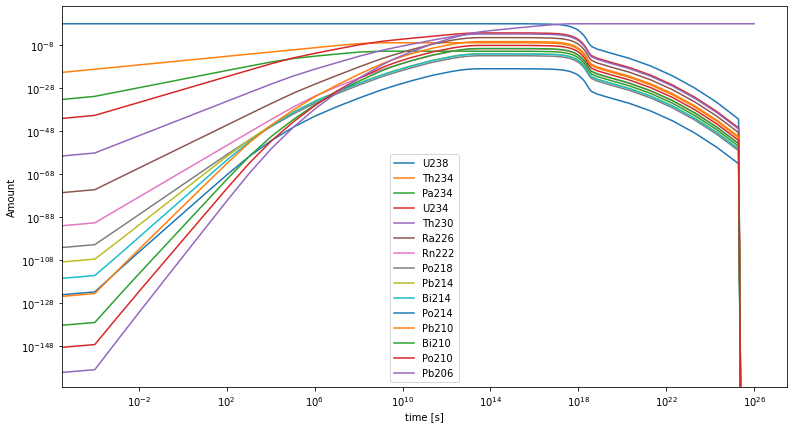

In [287]:
plt.figure(figsize=(13,7))

for i, ele in enumerate(half_lifeTable):
#     print(ele, i)
    plt.loglog(ans_stiff.t, ans_stiff.y[i,:], label=ele)
#     plt.semilogy(ans_stiff.t, ans_stiff.y[i,:], label=ele)

    
# plt.ylim(1e-60, 10)
# plt.xlim(0 ,1e25)
plt.xlabel("time [s]")
plt.ylabel("Amount")

plt.legend()
plt.show()

#### b) 
*Plot the ratio of Pb206 to U238 as a function of time over a region where it’s interesting. Does this make sense analytically? (If you look at the decay chain, all the half-lives are short compared to U238, so you can approximate the U238 decaying instantly to lead.*   
*Now plot the ratio of Thorium 230 to U234 over a region where that is interesting.    
Radioactive decay is frequently used to date rocks, and these results point at how you can determine the age of a uranium-bearing rock that is anywhere from thousands to billions of years old. (Of course, in this case the starting ratio of U234 to U238 would probably have already reached its long-term average when the rock was formed, but you could still use the U234/Th230 ratio under that assumption.)*

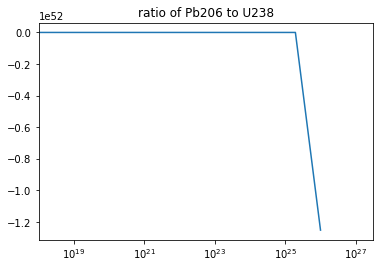

In [288]:
#do i have the half lives flipped? cause this seems to take a longgg time
plt.title("ratio of Pb206 to U238")
plt.semilogx(ans_stiff.t, ans_stiff.y[-1,:]/ans_stiff.y[0,:]) #Pb206 / U238

# plt.semilogx(ans_stiff.t, ans_stiff.y[0,:]) #Pb206 / U238
# plt.semilogx(ans_stiff.t, ans_stiff.y[-1,:]) #Pb206 / U238

plt.xlim(1e18,)
plt.show()


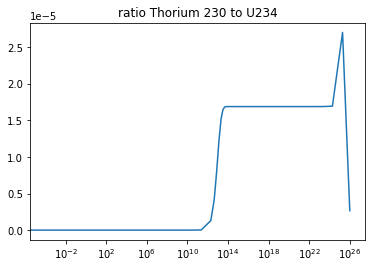

In [289]:
plt.title("ratio Thorium 230 to U234")
plt.semilogx(ans_stiff.t, ans_stiff.y[4,:]/ans_stiff.y[0,:]) #Pb206 / U238
# plt.xlim(1e10,1e16)
plt.show()